In [61]:

%pprint

Pretty printing has been turned OFF


In [121]:

import os
import cv2
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

textures_dir = '../data/1.12_Default_Resource_Pack/assets/minecraft/textures/blocks'
n_colors = 5
blocks_list = ['bookshelf.png', 'brick.png', 'coal_block.png', 'coal_ore.png', 'cobblestone.png',
               'cobblestone_mossy.png', 'crafting_table_front.png', 'crafting_table_side.png', 'diamond_block.png', 'diamond_ore.png',
               'dirt.png', 'dispenser_front_horizontal.png', 'dropper_front_horizontal.png', 'emerald_ore.png',
               'end_bricks.png', 'end_stone.png', 'furnace_front_off.png', 'furnace_side.png', 'glowstone.png',
               'gold_block.png', 'gold_ore.png', 'grass_side.png', 'gravel.png', 'hay_block_side.png',
               'ice.png', 'iron_block.png', 'iron_ore.png', 'jukebox_side.png', 'lapis_block.png',
               'lapis_ore.png', 'log_acacia.png', 'log_acacia_top.png', 'log_big_oak.png', 'log_big_oak_top.png',
               'log_birch.png', 'log_birch_top.png', 'log_jungle.png', 'log_jungle_top.png', 'log_oak.png',
               'log_oak_top.png', 'log_spruce.png', 'log_spruce_top.png', 'mushroom_block_skin_brown.png', 'mushroom_block_skin_red.png',
               'mushroom_block_skin_stem.png', 'mycelium_side.png', 'netherrack.png',
               'nether_brick.png', 'noteblock.png', 'obsidian.png', 'piston_side.png', 'planks_acacia.png',
               'planks_big_oak.png', 'planks_birch.png', 'planks_jungle.png', 'planks_oak.png', 'planks_spruce.png',
               'prismarine_bricks.png', 'prismarine_dark.png', 'pumpkin_face_off.png', 'pumpkin_side.png', 'purpur_block.png',
               'purpur_pillar.png', 'quartz_block_chiseled.png', 'quartz_block_chiseled_top.png', 'quartz_block_lines.png', 'quartz_block_lines_top.png',
               'quartz_block_side.png', 'quartz_block_top.png', 'quartz_ore.png', 'redstone_block.png', 'redstone_lamp_off.png',
               'redstone_ore.png', 'red_sand.png', 'red_sandstone_bottom.png', 'red_sandstone_carved.png', 'red_sandstone_normal.png',
               'red_sandstone_smooth.png', 'red_sandstone_top.png', 'sand.png', 'sandstone_bottom.png', 'sandstone_carved.png',
               'sandstone_normal.png', 'sandstone_smooth.png', 'sandstone_top.png', 'slime.png',
               'soul_sand.png', 'sponge.png', 'sponge_wet.png', 'stone.png', 'stonebrick.png',
               'stonebrick_carved.png', 'stonebrick_cracked.png', 'stonebrick_mossy.png', 'stone_andesite.png', 'stone_andesite_smooth.png',
               'stone_diorite.png', 'stone_diorite_smooth.png', 'stone_granite.png', 'stone_granite_smooth.png', 'stone_slab_side.png',
               'stone_slab_top.png', 'wool_colored_black.png', 'wool_colored_blue.png', 'wool_colored_brown.png',
               'wool_colored_cyan.png', 'wool_colored_gray.png', 'wool_colored_green.png', 'wool_colored_light_blue.png', 'wool_colored_lime.png',
               'wool_colored_magenta.png', 'wool_colored_orange.png', 'wool_colored_pink.png', 'wool_colored_purple.png', 'wool_colored_red.png',
               'wool_colored_silver.png', 'wool_colored_white.png', 'wool_colored_yellow.png']
AVERAGE_PALETTE = []
AVERAGE_DICT = {}
DOMINANT_PALETTE = []
DOMINANT_DICT = {}

In [122]:

def get_patches(img_array, n_colors=5):

    # Calculate the mean of each chromatic channel
    average = img_array.mean(axis=0).mean(axis=0)
    AVERAGE_PALETTE.extend(average)
    AVERAGE_DICT[file_name] = tuple(average)
    avg_patch = np.ones(shape=img_array.shape, dtype=np.uint8)*np.uint8(average)

    # Create a palette with the most representative colors
    pixels = np.float32(img_array.reshape(-1, 3))

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS

    _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
    _, counts = np.unique(labels, return_counts=True)

    # Get the palette color which occurs most frequently
    dominant = palette[np.argmax(counts)]
    DOMINANT_PALETTE.extend(dominant)
    DOMINANT_DICT[file_name] = tuple(dominant)
    dom_patch = np.ones(shape=img_array.shape, dtype=np.uint8)*np.uint8(dominant)

    indices = np.argsort(counts)[::-1]   
    freqs = np.cumsum(np.hstack([[0], counts[indices]/float(counts.sum())]))
    rows = np.int_(img_array.shape[0]*freqs)

    palette_patch = np.zeros(shape=img_array.shape, dtype=np.uint8)
    for i in range(len(rows) - 1):
        palette_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])
    
    return avg_patch, dom_patch, palette_patch

In [118]:

def show_images(avg_patch, dom_patch, palette_patch):
    fig, (original_ax, average_ax, palette_ax, dominant_ax) = plt.subplots(1, 4, figsize=(12, 6))
    original_ax.imshow(img_array)
    original_ax.set_title('Original texture')
    original_ax.axis('off')
    average_ax.imshow(avg_patch)
    average_ax.set_title('Average color')
    average_ax.axis('off')
    palette_ax.imshow(palette_patch)
    palette_ax.set_title('Color palette')
    palette_ax.axis('off')
    dominant_ax.imshow(dom_patch)
    dominant_ax.set_title('Dominant color')
    dominant_ax.axis('off')
    plt.suptitle(file_name.split('.')[0].replace('_', ' ').title(), y=0.75)
    plt.show(fig)

In [130]:

textures_dir = '../data/1.15_Default_Resource_Pack/assets/minecraft/textures/block'
AVERAGE_PALETTE = []
AVERAGE_DICT = {}
DOMINANT_PALETTE = []
DOMINANT_DICT = {}
blocks_list = []
for file_name in os.listdir(textures_dir):
    if file_name.endswith('.png'):
        
        # Read the image
        file_path = os.path.join(textures_dir, file_name)
        try:
            img_array = io.imread(file_path)[:, :, :-1]
            if img_array.shape == (16, 16, 3):
                avg_patch, dom_patch, palette_patch = get_patches(img_array)
                blocks_list.append(file_name)
        except IndexError as e:
            print(f'{file_name}: {str(e).strip()}')

grass_block_top.png: too many indices for array: array is 2-dimensional, but 3 were indexed


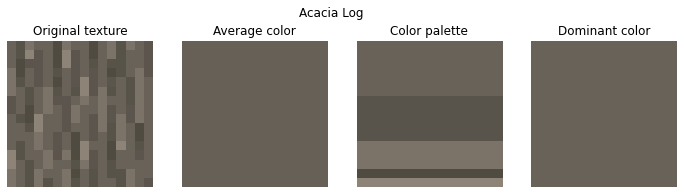

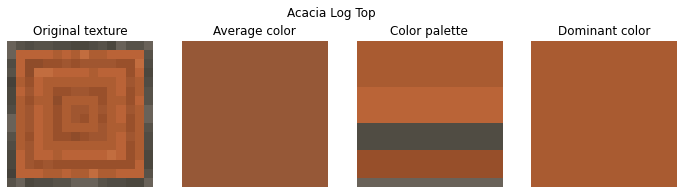

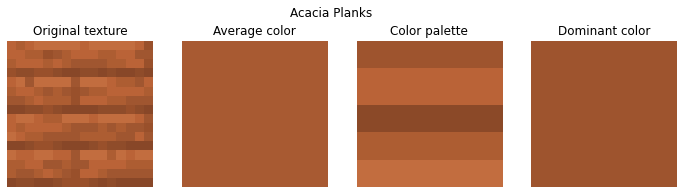

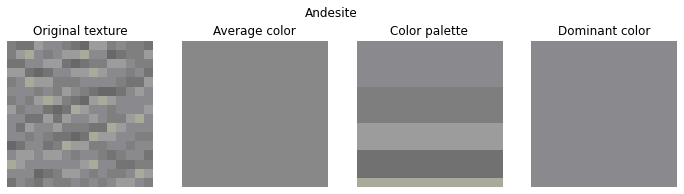

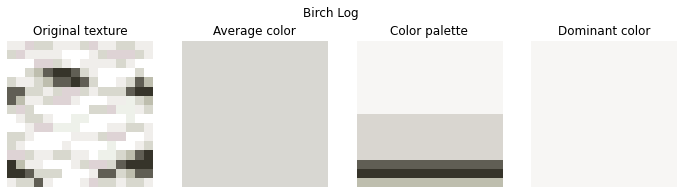

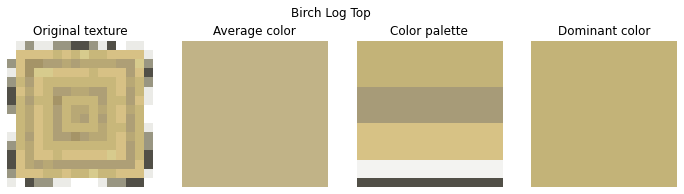

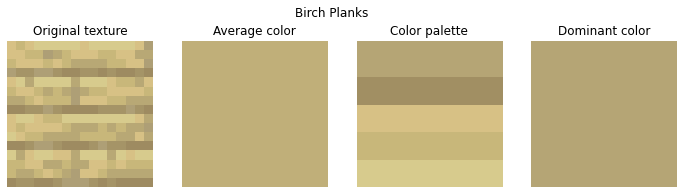

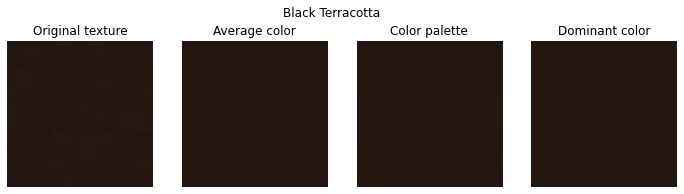

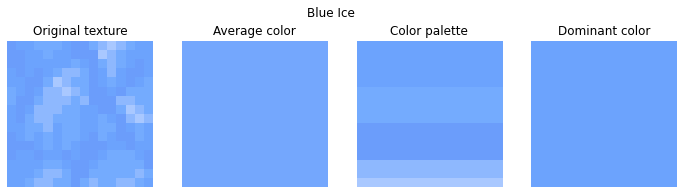

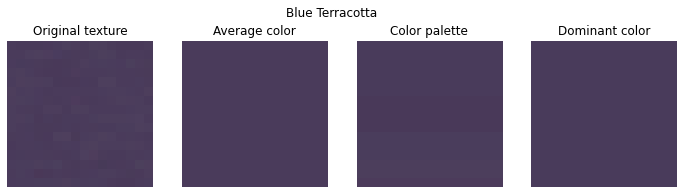

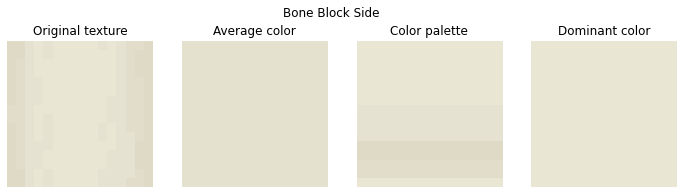

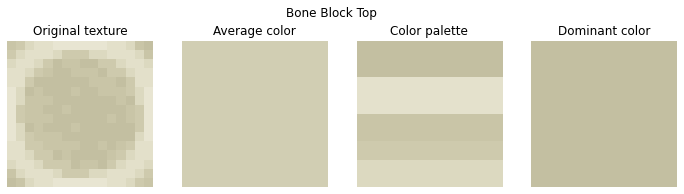

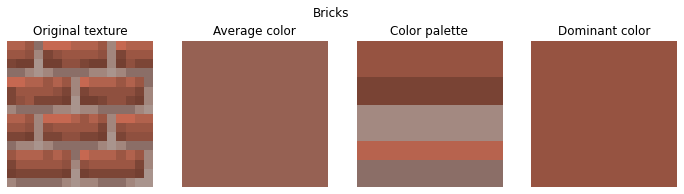

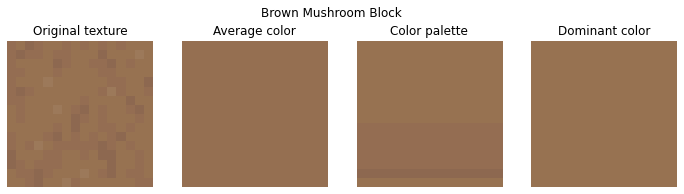

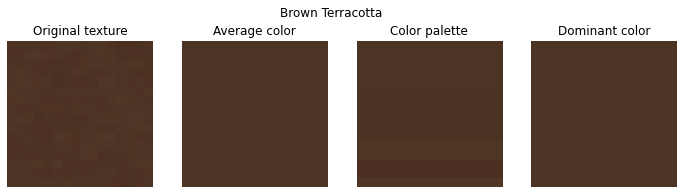

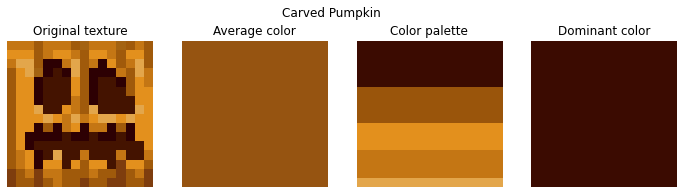

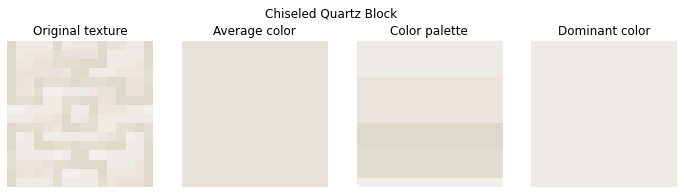

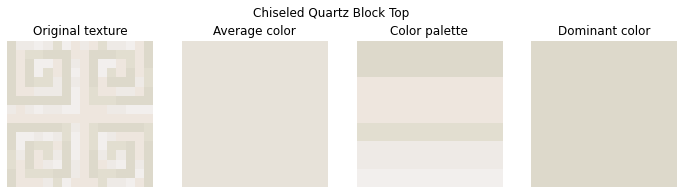

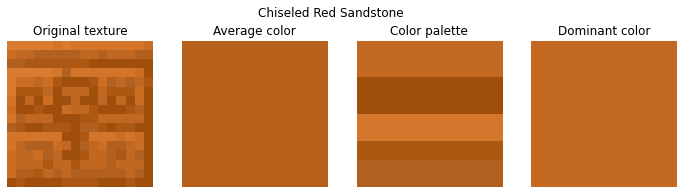

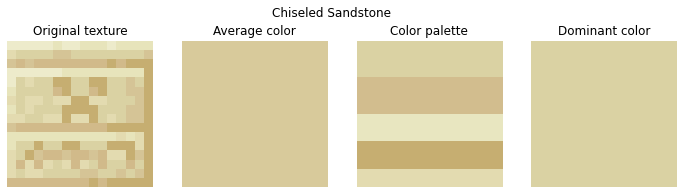

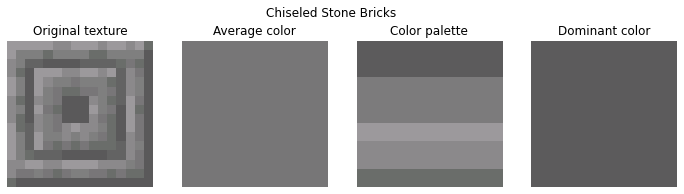

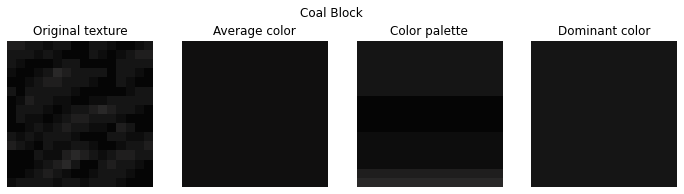

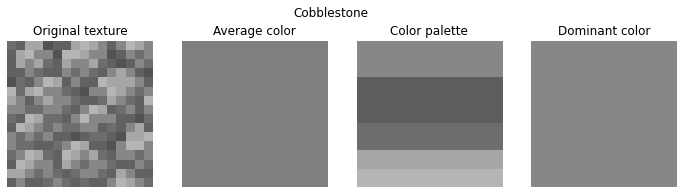

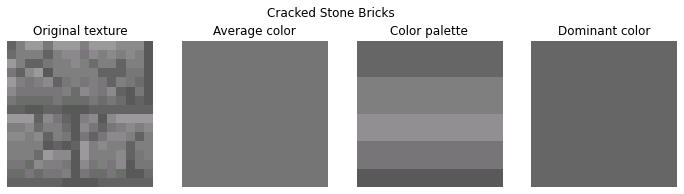

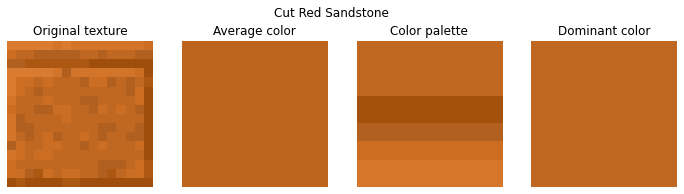

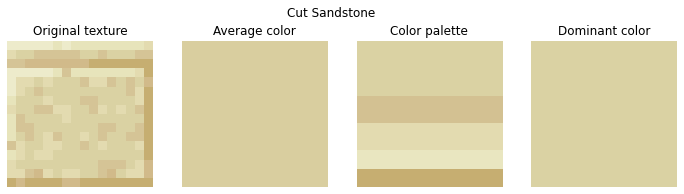

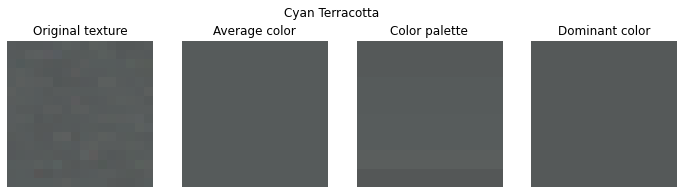

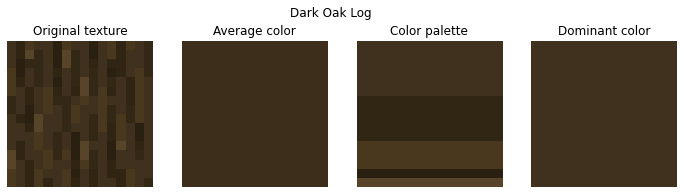

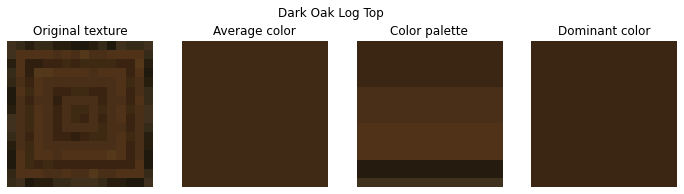

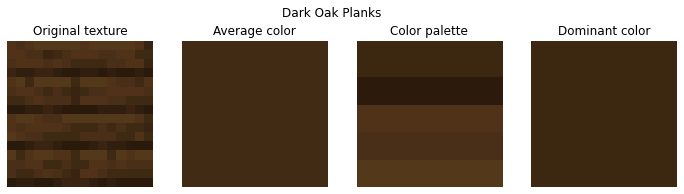

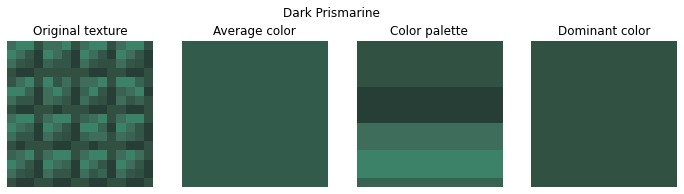

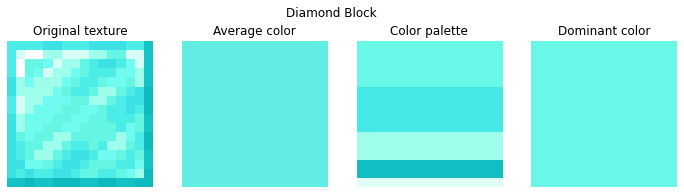

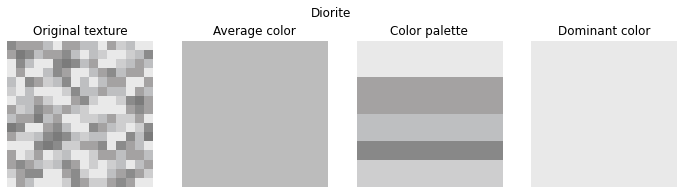

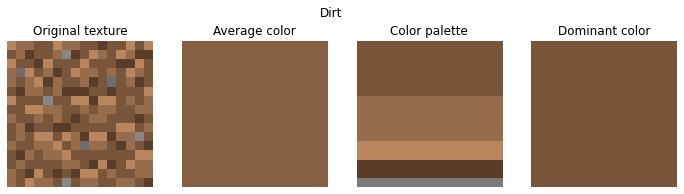

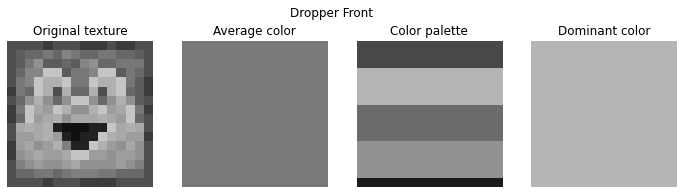

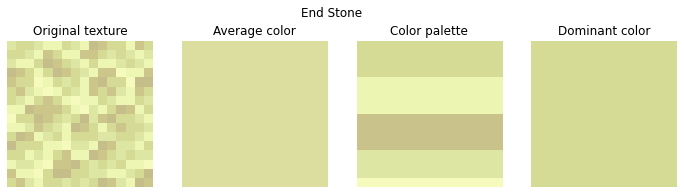

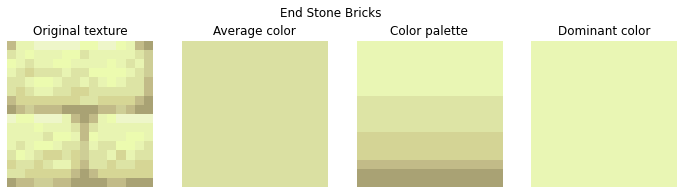

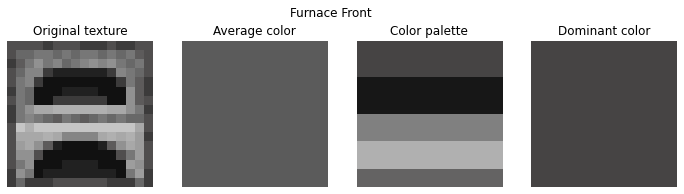

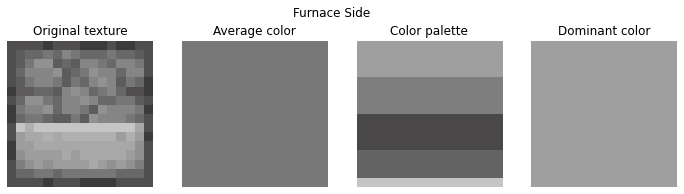

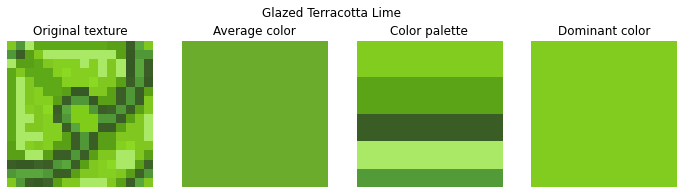

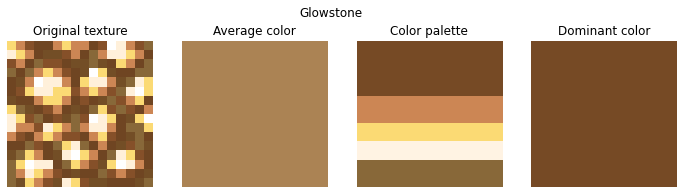

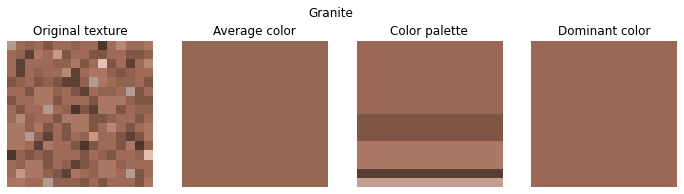

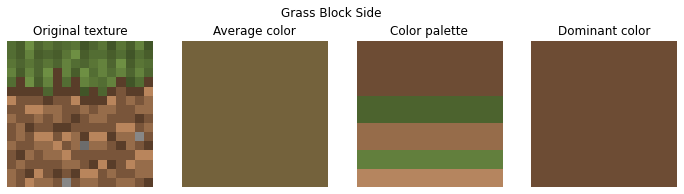

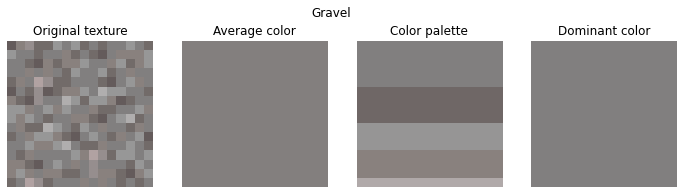

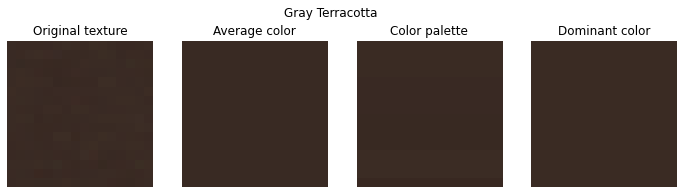

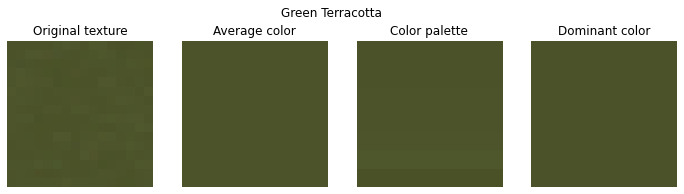

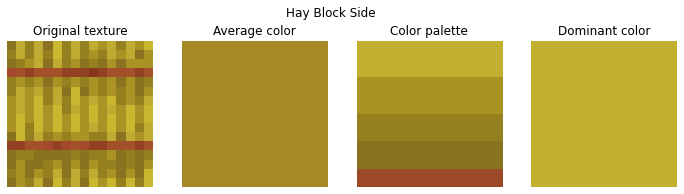

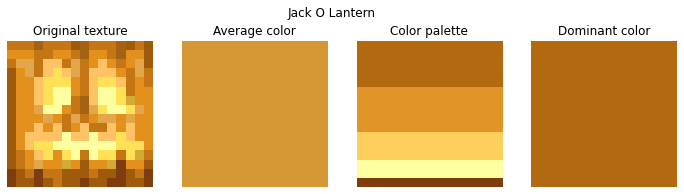

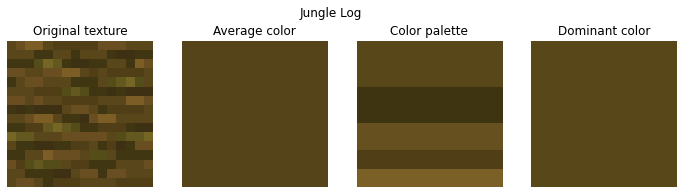

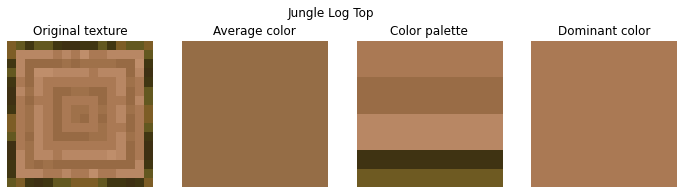

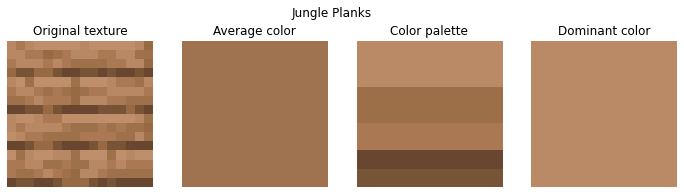

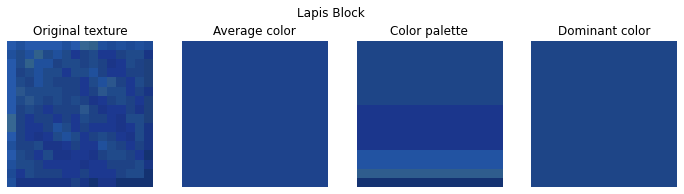

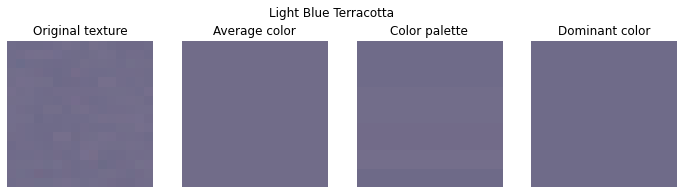

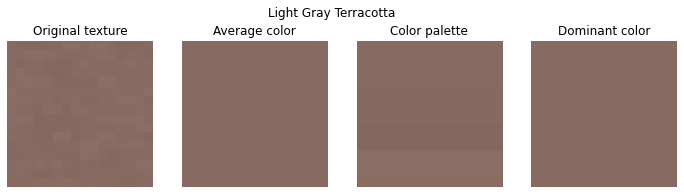

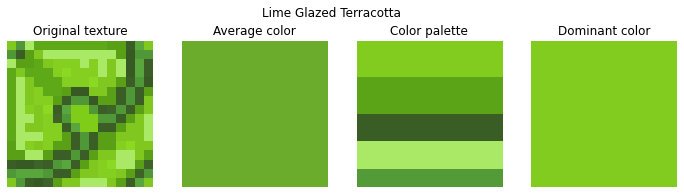

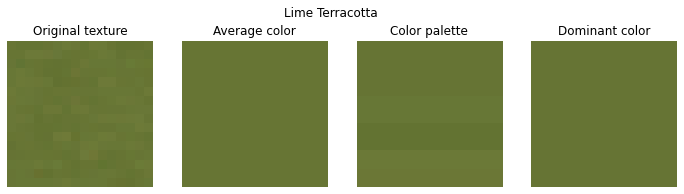

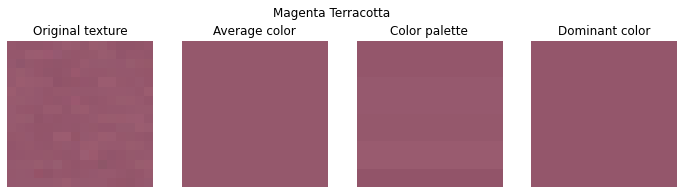

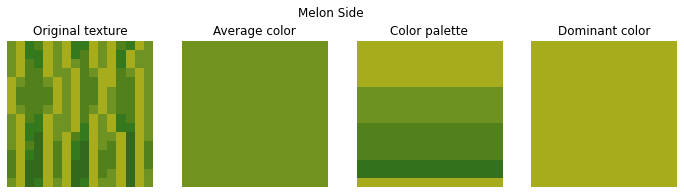

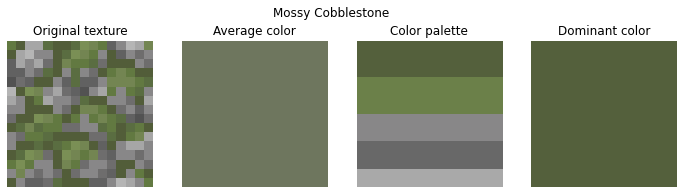

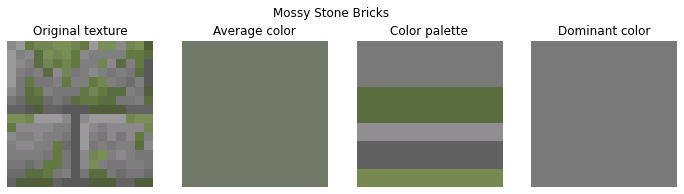

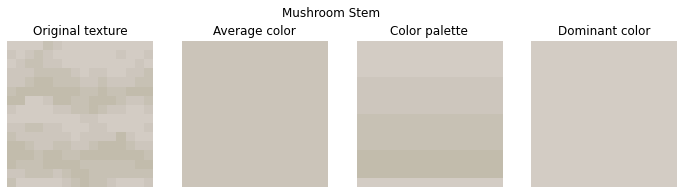

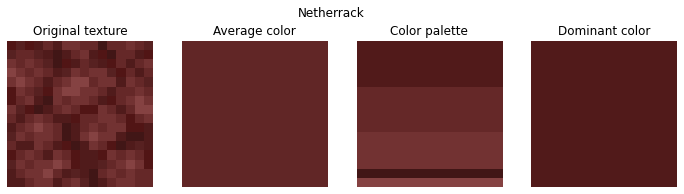

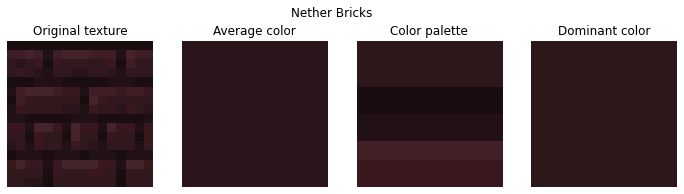

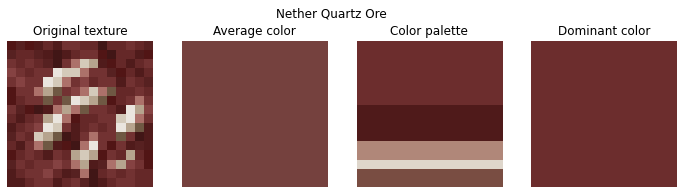

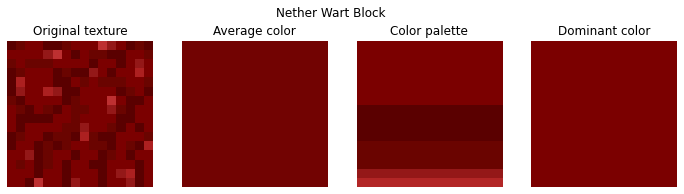

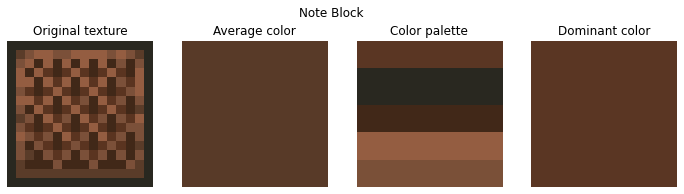

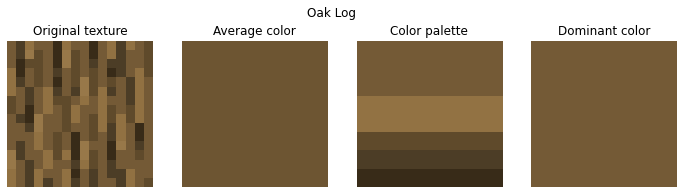

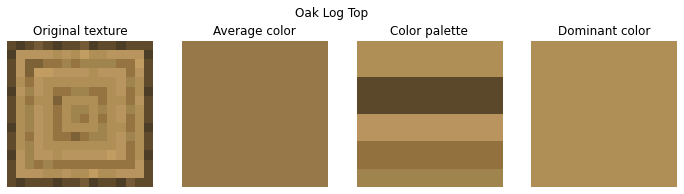

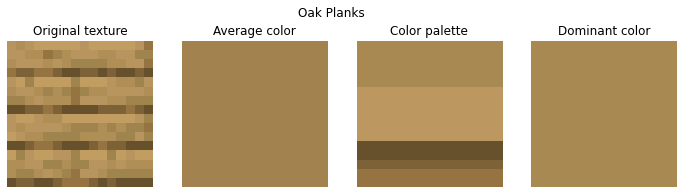

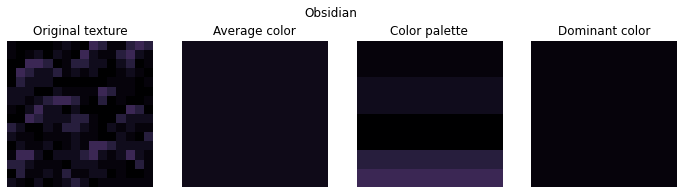

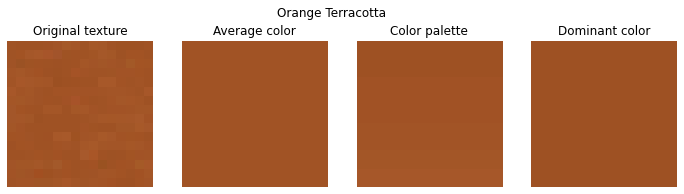

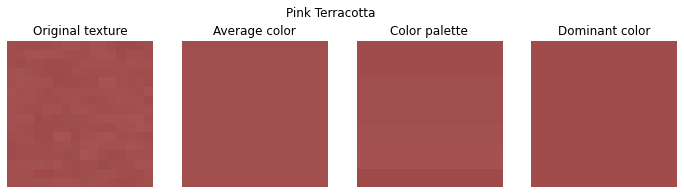

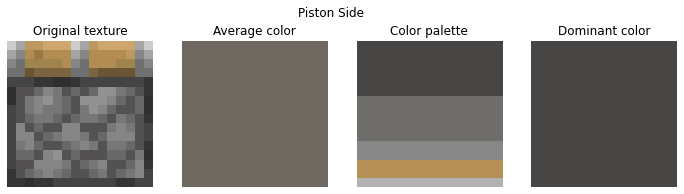

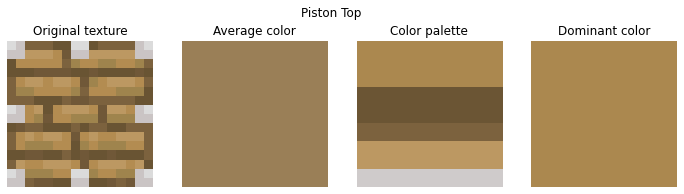

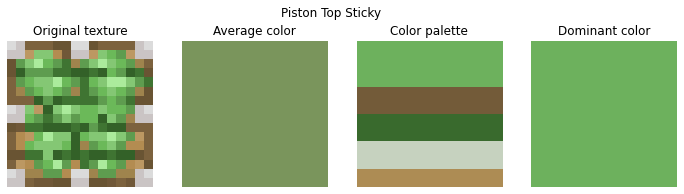

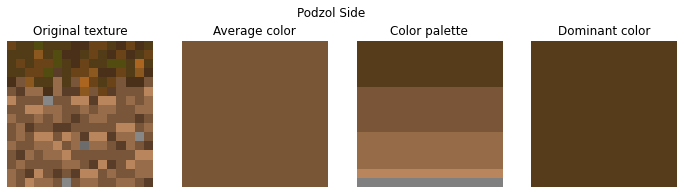

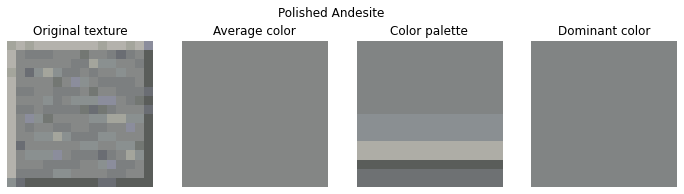

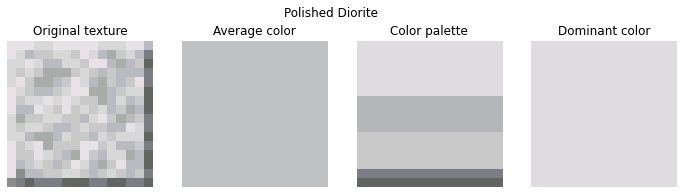

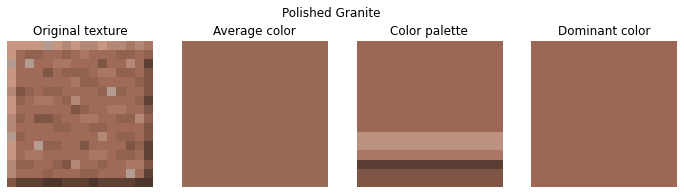

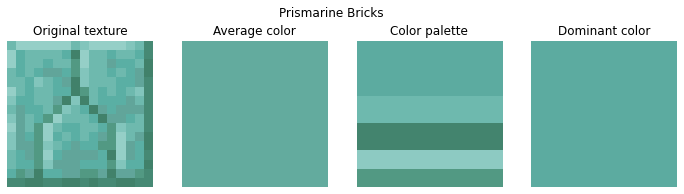

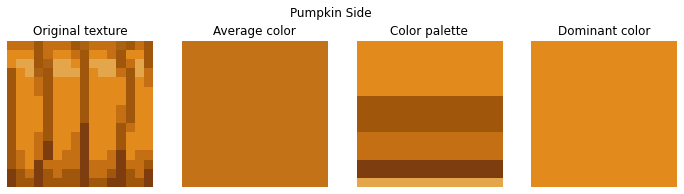

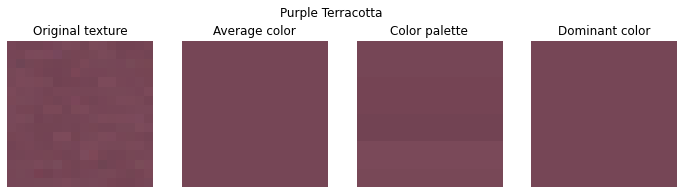

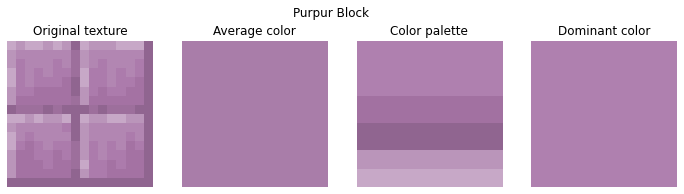

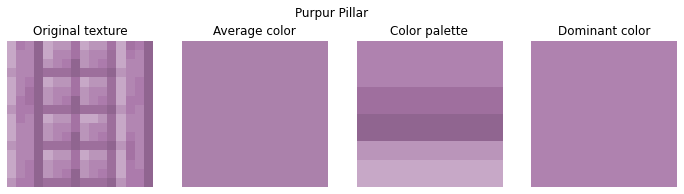

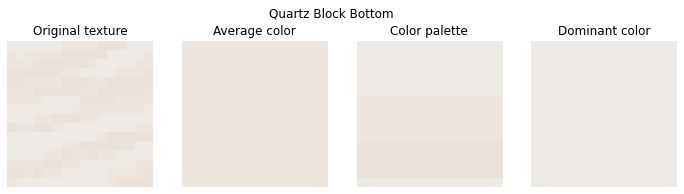

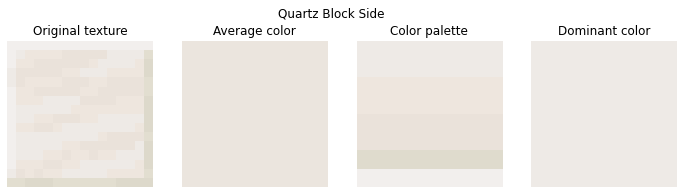

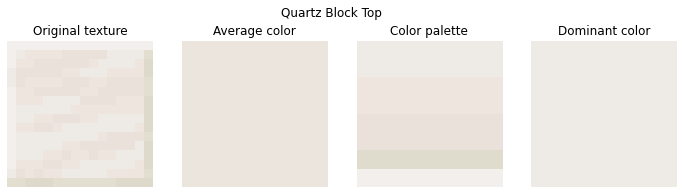

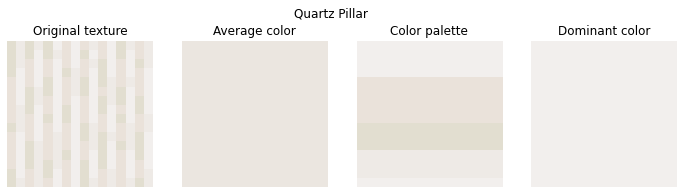

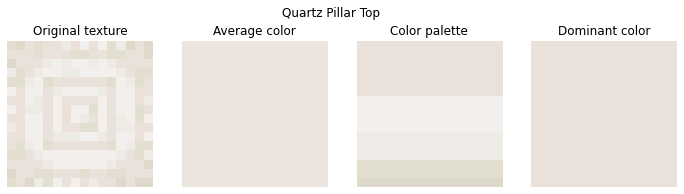

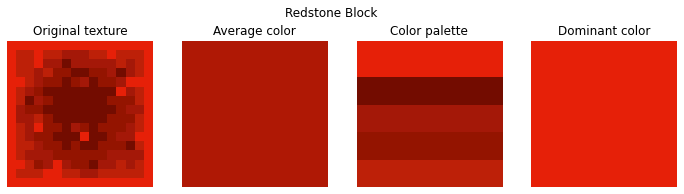

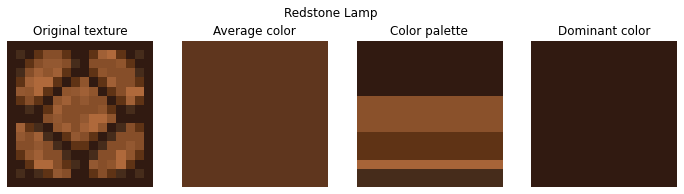

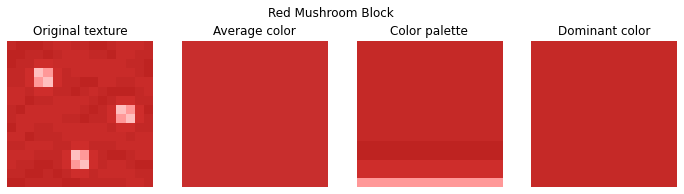

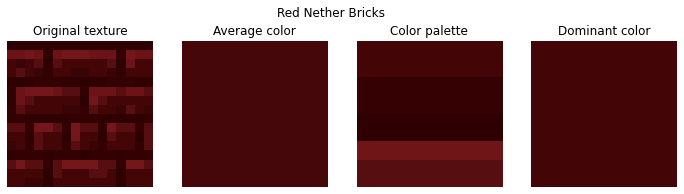

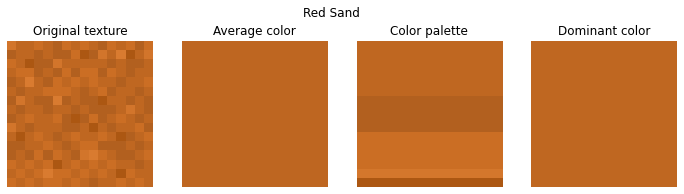

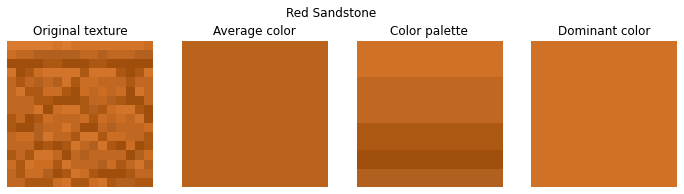

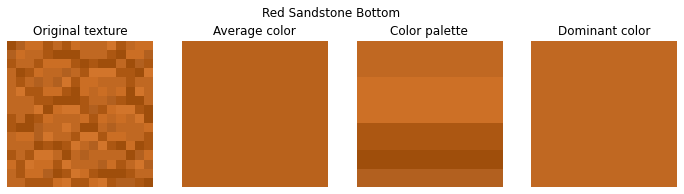

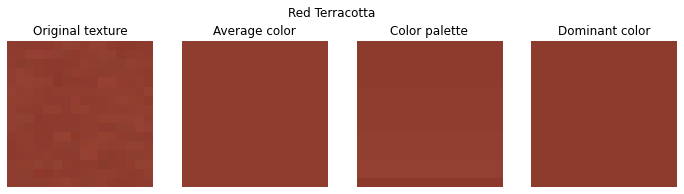

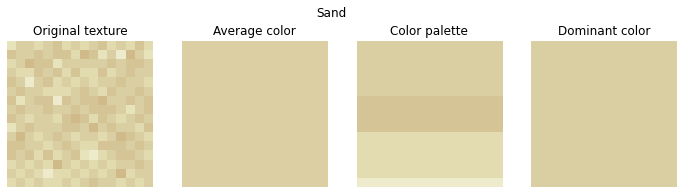

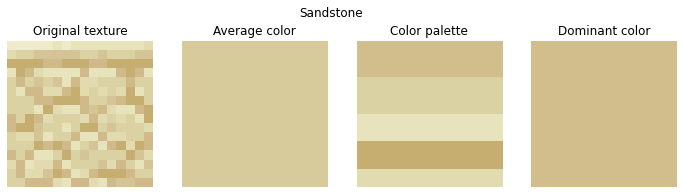

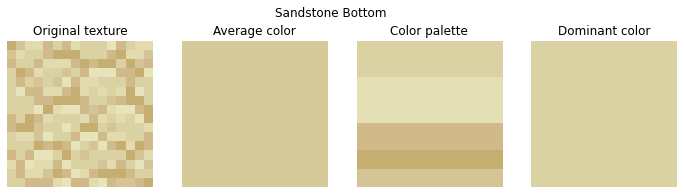

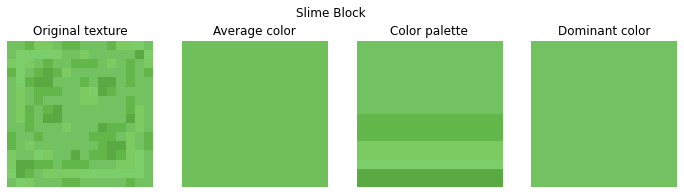

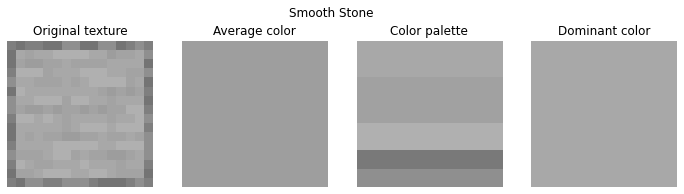

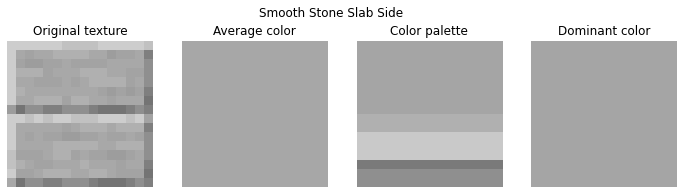

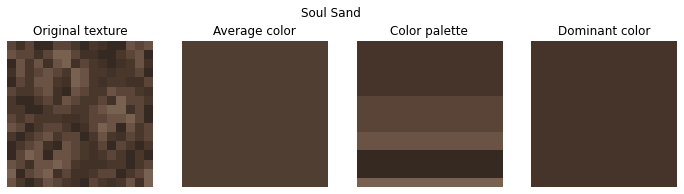

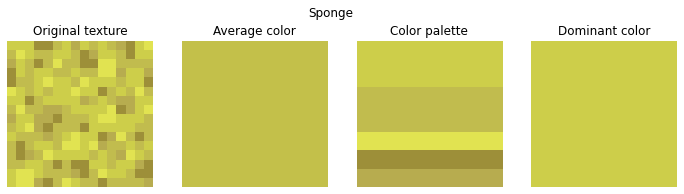

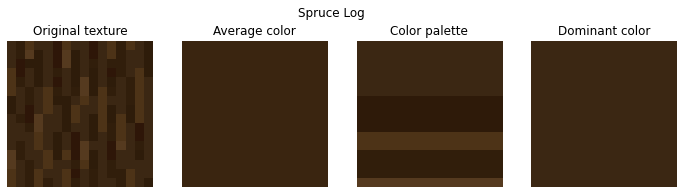

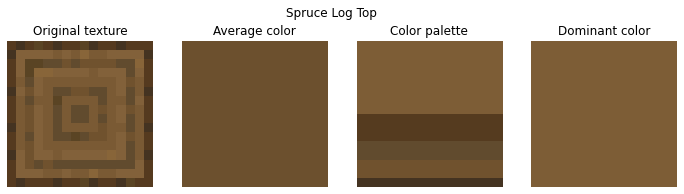

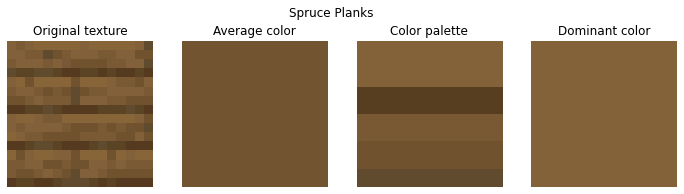

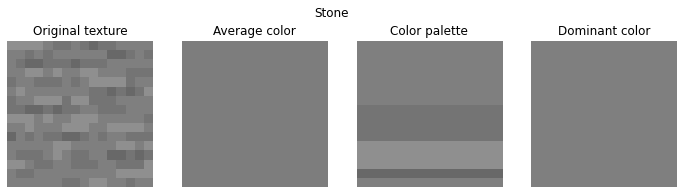

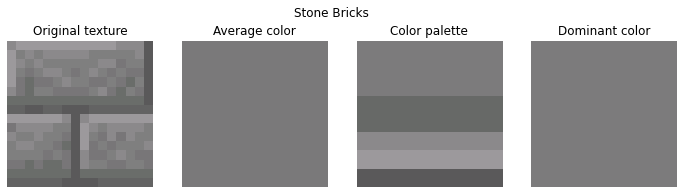

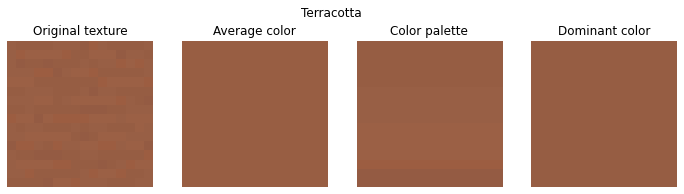

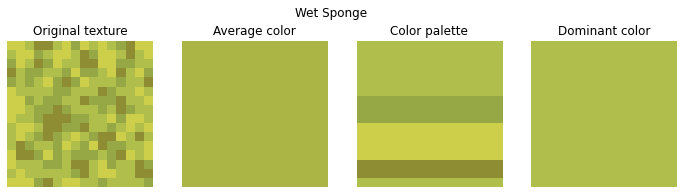

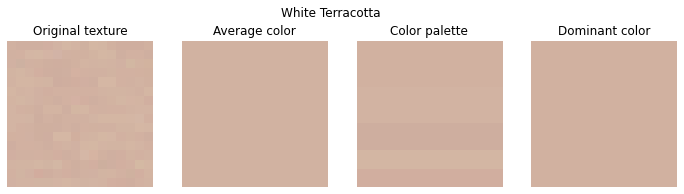

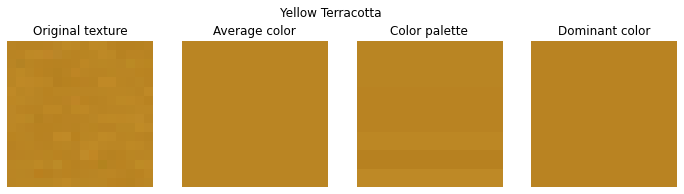

In [139]:

blocks_list = ['acacia_log.png', 'acacia_log_top.png', 'acacia_planks.png', 'andesite.png', 'birch_log.png',
               'birch_log_top.png', 'birch_planks.png', 'black_terracotta.png', 'blue_ice.png', 'blue_terracotta.png',
               'bone_block_side.png', 'bone_block_top.png', 'bricks.png', 'brown_mushroom_block.png', 'brown_terracotta.png',
               'carved_pumpkin.png', 'chiseled_quartz_block.png', 'chiseled_quartz_block_top.png', 'chiseled_red_sandstone.png', 'chiseled_sandstone.png',
               'chiseled_stone_bricks.png', 'coal_block.png', 'cobblestone.png', 'cracked_stone_bricks.png', 'cut_red_sandstone.png',
               'cut_sandstone.png', 'cyan_terracotta.png', 'dark_oak_log.png', 'dark_oak_log_top.png', 'dark_oak_planks.png',
               'dark_prismarine.png', 'diamond_block.png', 'diorite.png', 'dirt.png', 'dropper_front.png',
               'end_stone.png', 'end_stone_bricks.png', 'furnace_front.png', 'furnace_side.png', 'glazed_terracotta_lime.png',
               'glowstone.png', 'granite.png', 'grass_block_side.png', 'gravel.png',
               'gray_terracotta.png', 'green_terracotta.png', 'hay_block_side.png', 'jack_o_lantern.png', 'jungle_log.png',
               'jungle_log_top.png', 'jungle_planks.png', 'lapis_block.png', 'light_blue_terracotta.png', 'light_gray_terracotta.png',
               'lime_glazed_terracotta.png', 'lime_terracotta.png', 'magenta_terracotta.png', 'melon_side.png', 'mossy_cobblestone.png',
               'mossy_stone_bricks.png', 'mushroom_stem.png', 'netherrack.png', 'nether_bricks.png', 'nether_quartz_ore.png',
               'nether_wart_block.png', 'note_block.png', 'oak_log.png', 'oak_log_top.png', 'oak_planks.png',
               'obsidian.png', 'orange_terracotta.png', 'pink_terracotta.png', 'piston_side.png', 'piston_top.png',
               'piston_top_sticky.png', 'podzol_side.png', 'polished_andesite.png', 'polished_diorite.png', 'polished_granite.png',
               'prismarine_bricks.png', 'pumpkin_side.png', 'purple_terracotta.png', 'purpur_block.png', 'purpur_pillar.png',
               'quartz_block_bottom.png', 'quartz_block_side.png', 'quartz_block_top.png', 'quartz_pillar.png', 'quartz_pillar_top.png',
               'redstone_block.png', 'redstone_lamp.png', 'red_mushroom_block.png', 'red_nether_bricks.png',
               'red_sand.png', 'red_sandstone.png', 'red_sandstone_bottom.png', 'red_terracotta.png', 'sand.png',
               'sandstone.png', 'sandstone_bottom.png', 'slime_block.png', 'smooth_stone.png', 'smooth_stone_slab_side.png',
               'soul_sand.png', 'sponge.png', 'spruce_log.png', 'spruce_log_top.png', 'spruce_planks.png',
               'stone.png', 'stone_bricks.png', 'terracotta.png', 'wet_sponge.png', 'white_terracotta.png',
               'yellow_terracotta.png']
textures_dir = '../data/1.15_Default_Resource_Pack/assets/minecraft/textures/block'
AVERAGE_PALETTE = []
AVERAGE_DICT = {}
DOMINANT_PALETTE = []
DOMINANT_DICT = {}
for file_name in blocks_list:
    
    # Read the image
    file_path = os.path.join(textures_dir, file_name)
    img_array = io.imread(file_path)[:, :, :-1]
    
    avg_patch, dom_patch, palette_patch = get_patches(img_array)
    show_images(avg_patch, dom_patch, palette_patch)

In [140]:

import pandas as pd

rows_list = []
img_array = np.array(minecraft_pixel_art_img)
row_count = img_array.shape[0]
col_count = img_array.shape[1]
for row in range(row_count):
    print()
    print()
    for col in range(col_count):
        block_name = sorted(AVERAGE_DICT.items(), key=lambda item: np.linalg.norm(np.array(item[1])-img_array[row][col]))[0][0].split('.')[0].replace('_', ' ').title()
        print(block_name, end=' / ')
        row_dict = {}
        row_dict['row_number'] = row
        row_dict['column_number'] = col
        row_dict['block_name'] = block_name
        rows_list.append(row_dict)
block_names_df = pd.DataFrame(rows_list)
print()
print()
print('-------')
print()
print()
block_names_series = block_names_df.block_name.value_counts()
for column_name, column_value in block_names_series.iteritems():
    stack_count = (column_value // 64) + 1
    stack_str = 's' if stack_count > 1 else ''
    print(f'{column_name}: {column_value} ({stack_count} stack{stack_str})')



Diorite / Light Blue Terracotta / Lapis Block / Coal Block / Sand / Sand / Glowstone / Glowstone / Acacia Planks / Red Terracotta / Netherrack / Coal Block / Birch Log Top / Brown Mushroom Block / Spruce Log Top / Coal Block / Birch Log / White Terracotta / White Terracotta / Coal Block / Coal Block / Quartz Block Bottom / Coal Block / Coal Block / Dark Prismarine / Piston Top Sticky / Dark Prismarine / Coal Block / Coal Block / Quartz Block Bottom / Coal Block / Coal Block / White Terracotta / White Terracotta / Birch Log / Coal Block / Spruce Log Top / Brown Mushroom Block / Birch Log Top / Coal Block / Netherrack / Red Terracotta / Acacia Planks / Glowstone / Glowstone / Sand / Sand / Coal Block / Lapis Block / Light Blue Terracotta / Diorite / 

Coal Block / Diorite / Light Blue Terracotta / Lapis Block / Coal Block / Sand / Sand / Glowstone / Glowstone / Acacia Planks / Coal Block / Birch Log Top / Brown Mushroom Block / Spruce Log Top / Coal Block / Birch Log / White Terracotta


----

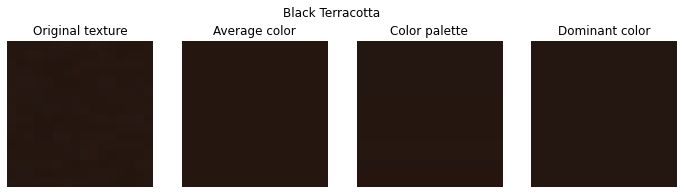

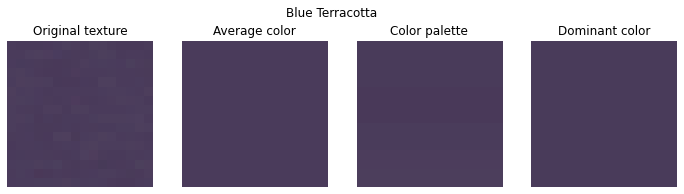

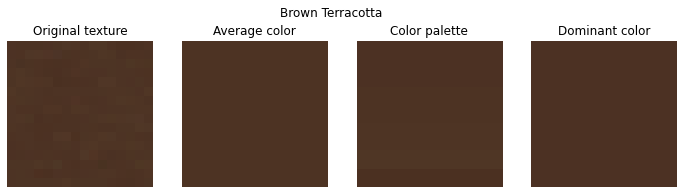

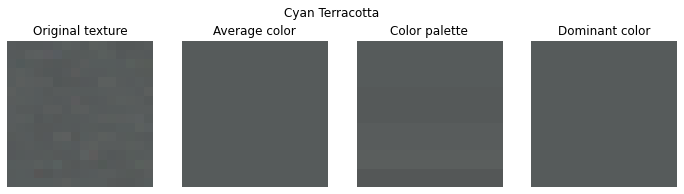

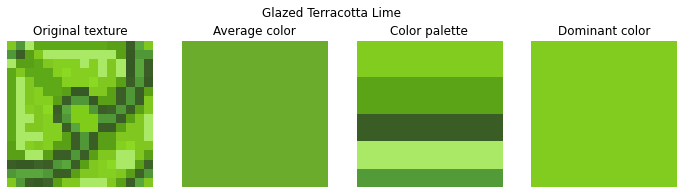

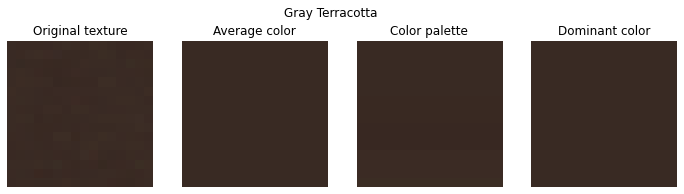

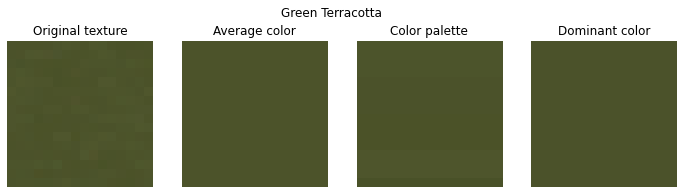

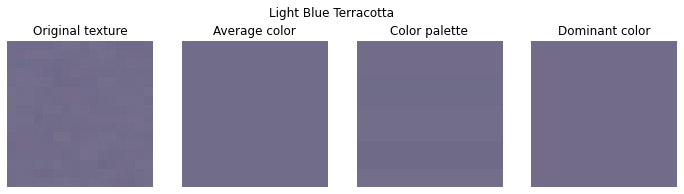

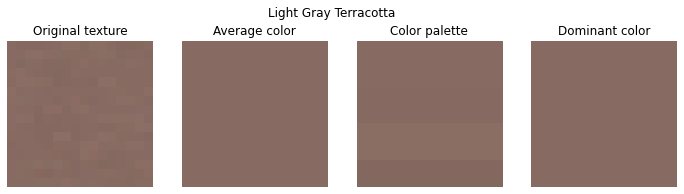

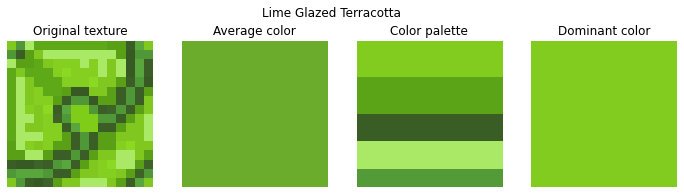

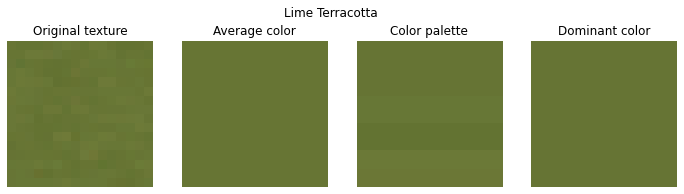

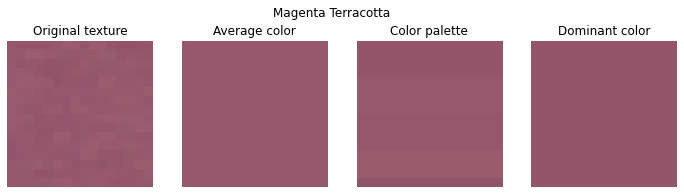

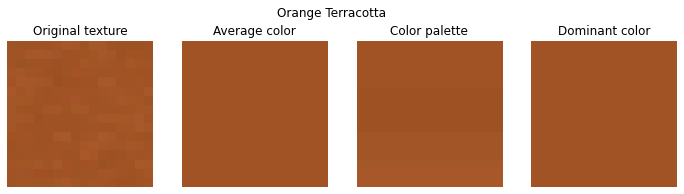

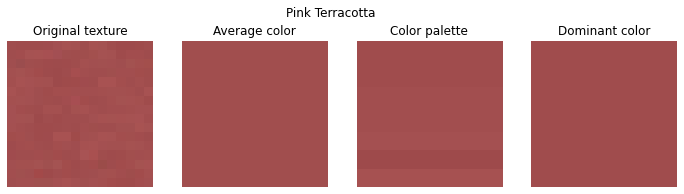

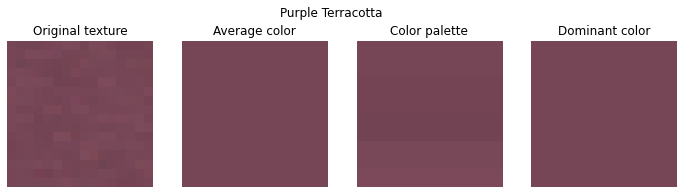

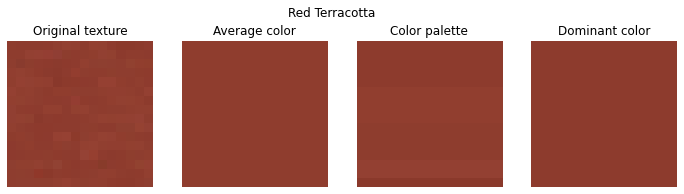

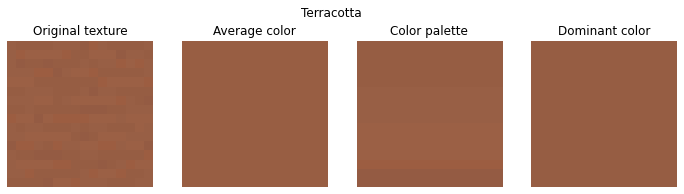

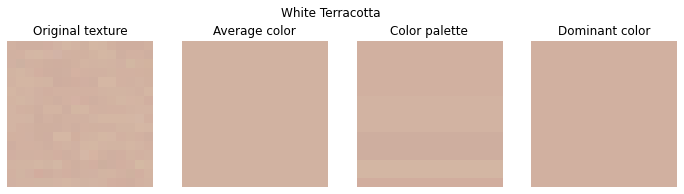

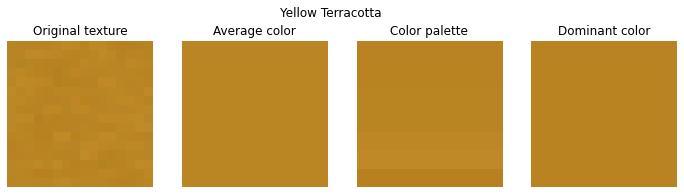

In [125]:

textures_dir = '../data/1.15_Default_Resource_Pack/assets/minecraft/textures/block'
blocks_list = []
for file_name in os.listdir(textures_dir):
    if file_name.endswith('.png') and ('terracotta' in file_name):
        
        # Read the image
        file_path = os.path.join(textures_dir, file_name)
        img_array = io.imread(file_path)[:, :, :-1]
        if img_array.shape == (16, 16, 3):
            avg_patch, dom_patch, palette_patch = get_patches(img_array)
            show_images(avg_patch, dom_patch, palette_patch)
            blocks_list.append(file_name)

In [86]:

from PIL import Image

def quantizetopalette(silf, palette, dither=False):
    '''Convert an RGB or L mode image to use a given P image's palette.'''

    silf.load()

    # Use palette from reference image
    palette.load()
    if palette.mode != 'P':
        raise ValueError('bad mode for palette image')
    if silf.mode != 'RGB' and silf.mode != 'L':
        raise ValueError(
            'only RGB or L mode images can be quantized to a palette'
            )
    
    # Turn OFF dithering by default
    im = silf.im.convert('P', int(bool(dither)), palette.im)

    # Later versions of Pillow (4.x) rename _makeself to _new
    try:
        return silf._new(im)
    except AttributeError:
        return silf._makeself(im)

palimage = Image.new('P', (16, 16))
palimage.putpalette([int(n) for n in AVERAGE_PALETTE])
minecraft_pixel_art_img = Image.open('../saves/png/minecraft_pixel_art.png')
new_img = quantizetopalette(minecraft_pixel_art_img, palimage, dither=False)

In [87]:

[f'new_img.{fn}' for fn in dir(new_img) if not fn.startswith('_')]

['new_img.alpha_composite', 'new_img.close', 'new_img.convert', 'new_img.copy', 'new_img.crop', 'new_img.draft', 'new_img.effect_spread', 'new_img.entropy', 'new_img.filter', 'new_img.format', 'new_img.format_description', 'new_img.frombytes', 'new_img.getbands', 'new_img.getbbox', 'new_img.getchannel', 'new_img.getcolors', 'new_img.getdata', 'new_img.getexif', 'new_img.getextrema', 'new_img.getim', 'new_img.getpalette', 'new_img.getpixel', 'new_img.getprojection', 'new_img.height', 'new_img.histogram', 'new_img.im', 'new_img.info', 'new_img.load', 'new_img.mode', 'new_img.palette', 'new_img.paste', 'new_img.point', 'new_img.putalpha', 'new_img.putdata', 'new_img.putpalette', 'new_img.putpixel', 'new_img.pyaccess', 'new_img.quantize', 'new_img.readonly', 'new_img.reduce', 'new_img.remap_palette', 'new_img.resize', 'new_img.rotate', 'new_img.save', 'new_img.seek', 'new_img.show', 'new_img.size', 'new_img.split', 'new_img.tell', 'new_img.thumbnail', 'new_img.tobitmap', 'new_img.tobytes',

In [88]:

minecraft_pixel_art_img.getpixel((1, 1))

(165, 192, 201)

In [90]:

from PIL import Image

def chunk(seq, size, groupByList=True):
    '''Returns list of lists/tuples broken up by size input'''
    func = tuple
    if groupByList:
        func = list
    return [func(seq[i:i + size]) for i in range(0, len(seq), size)]


def get_palette_in_rgb(img):
    '''
    Returns list of RGB tuples found in the image palette
    :type img: Image.Image
    :rtype: list[tuple]
    '''
    assert img.mode == 'P', 'image should be palette mode'
    pal = img.getpalette()
    colors = chunk(pal, 3, False)
    return colors

# Usage
get_palette_in_rgb(new_img)

[(107, 88, 57), (146, 99, 86), (18, 18, 18), (115, 115, 115), (122, 122, 122), (103, 121, 103), (115, 95, 63), (118, 95, 60), (97, 219, 213), (129, 140, 143), (134, 96, 67), (116, 116, 116), (116, 116, 116), (109, 128, 116), (225, 230, 170), (221, 223, 165), (78, 78, 78), (113, 113, 113), (143, 118, 69), (249, 236, 78), (143, 139, 124), (126, 107, 65), (126, 124, 122), (157, 116, 18), (125, 173, 255), (219, 219, 219), (135, 130, 126), (100, 67, 50), (38, 67, 137), (102, 112, 134), (105, 99, 89), (154, 91, 64), (52, 40, 23), (78, 62, 41), (206, 206, 201), (184, 166, 121), (87, 67, 26), (153, 118, 73), (102, 81, 49), (154, 125, 77), (45, 28, 12), (104, 81, 48), (141, 106, 83), (182, 37, 36), (207, 204, 194), (113, 88, 73), (111, 54, 52), (44, 22, 26), (100, 67, 50), (20, 18, 29), (106, 102, 95), (169, 91, 51), (61, 39, 18), (195, 179, 123), (154, 110, 77), (156, 127, 78), (103, 77, 46), (99, 160, 143), (59, 87, 75), (142, 76, 12), (197, 120, 23), (166, 121, 166), (170, 126, 170), (231, 2

In [91]:

minecraft_pixel_art_img.convert('RGB').getpixel((1, 1))

(165, 192, 201)

In [95]:

np.array(minecraft_pixel_art_img)[0][0]

array([165, 192, 201], dtype=uint8)

In [96]:

np.array(AVERAGE_DICT['bookshelf.png'])

array([107.9609375,  88.1640625,  57.5625   ])

In [97]:

np.linalg.norm(np.array(AVERAGE_DICT['bookshelf.png'])-np.array(minecraft_pixel_art_img)[0][0])

186.0367516745893

In [100]:

sorted(AVERAGE_DICT.items(), key=lambda item: np.linalg.norm(np.array(item[1])-np.array(minecraft_pixel_art_img)[0][0]))[0][0]

'stone_diorite_smooth.png'

In [101]:

np.array(minecraft_pixel_art_img).shape

(9, 51, 3)

In [103]:

i = 0
for index, elem in np.ndenumerate(np.array(minecraft_pixel_art_img)):
    print(index, elem)
    i += 1
    if i > 10:
        break

(0, 0, 0) 165
(0, 0, 1) 192
(0, 0, 2) 201
(0, 1, 0) 96
(0, 1, 1) 125
(0, 1, 2) 159
(0, 2, 0) 50
(0, 2, 1) 63
(0, 2, 2) 118
(0, 3, 0) 0
(0, 3, 1) 0


In [2]:

[f'os.{fn}' for fn in dir(os) if 'dir' in fn]

['os.add_dll_directory',
 'os.chdir',
 'os.curdir',
 'os.listdir',
 'os.makedirs',
 'os.mkdir',
 'os.pardir',
 'os.removedirs',
 'os.rmdir',
 'os.scandir',
 'os.supports_dir_fd']